In [21]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm
from patsy import dmatrices
import statsmodels.formula.api as smf
from sklearn.preprocessing import MinMaxScaler

### Exploratory Data Analysis

### Loading in data


In [22]:
df = pd.read_csv("final_data.csv")

###Averaged version of the data
Creates an averaged version of the data set, with just 1 row for each local authority, rather than 5. Used for linear regressions later on.

In [23]:
#average  each variable over all the years for each LA
averaged_df = df.groupby('la_code').mean(numeric_only = True)


#look at new shape and variable names
averaged_df.shape, averaged_df.info()

#150 rows (for each LA), 42 features

<class 'pandas.core.frame.DataFrame'>
Index: 150 entries, E06000001 to E10000034
Data columns (total 43 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   Unnamed: 0                     150 non-null    float64
 1   reporting_year                 150 non-null    float64
 2   academic_year                  150 non-null    float64
 3   pt_ks2_expectations            101 non-null    float64
 4   pt_ks4_expectations            141 non-null    float64
 5   avg_p8score                    146 non-null    float64
 6   num_convictions                139 non-null    float64
 7   num_placed_inside_la           150 non-null    float64
 8   pt_convictions                 139 non-null    float64
 9   pt_placed_inside_la            150 non-null    float64
 10  num_substance                  146 non-null    float64
 11  num_private_provis             150 non-null    float64
 12  pt_substance                   146 non-nu

((150, 43), None)

## Looking at the distribution of each variable individually

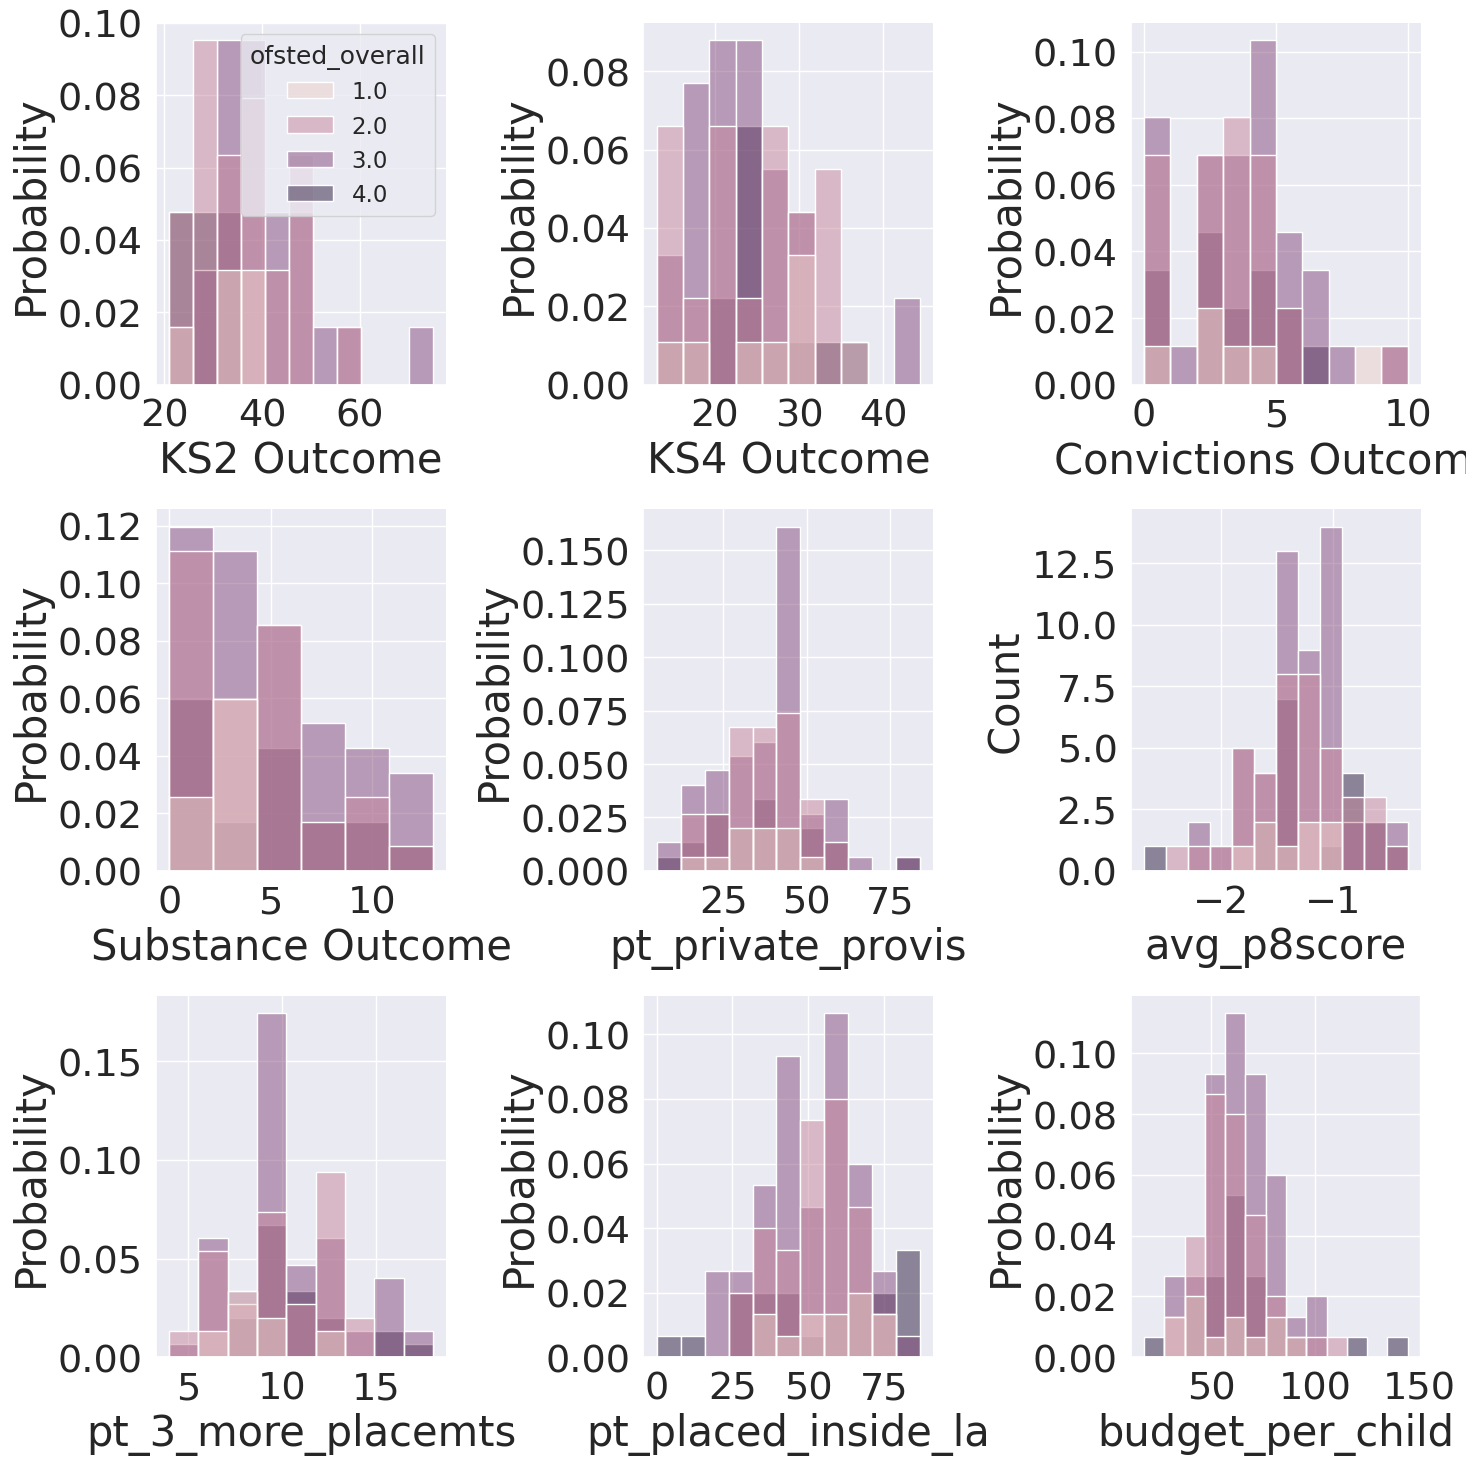

In [24]:
#visualize the distribution of each variable with a histogram, colouring each bar by ofsted rating
sns.set_palette("viridis", n_colors = 4)
fig, axs = plt.subplots(3, 3, figsize = (15,15))
sns.set(font_scale=1.5)
sns.histplot(data = df, x = 'pt_ks2_expectations', ax = axs[0,0], stat = 'probability', binwidth = 5, hue = 'ofsted_overall', legend = True)
axs[0,0].set_xlabel("KS2 Outcome")
sns.despine()
sns.histplot(data = df, x = 'pt_ks4_expectations', ax = axs[0,1], stat = 'probability', binwidth = 3, hue = 'ofsted_overall', legend = False)
axs[0,1].set_xlabel("KS4 Outcome")
sns.despine()

sns.histplot(data = df, x = 'pt_convictions', ax = axs[0,2], stat = 'probability', binwidth = 1, hue = 'ofsted_overall', legend = False)
axs[0,2].set_xlabel("Convictions Outcome")
sns.despine()

sns.histplot(data = df, x = 'pt_3_more_placemts', ax = axs[2,0], stat = 'probability', binwidth = 1.5, hue = 'ofsted_overall', legend = False)

sns.despine()
sns.histplot(data = df, x = 'pt_substance', ax = axs[1,0], stat = 'probability', binwidth = 2, hue = 'ofsted_overall', legend = False)
axs[1,0].set_xlabel("Substance Outcome")
sns.despine()
sns.histplot(data = df, x = 'pt_placed_inside_la', ax = axs[2,1], stat = 'probability', binwidth = 8, hue = 'ofsted_overall', legend = False)
sns.despine()
sns.histplot(data = df, x = 'pt_private_provis', ax = axs[1,1], stat = 'probability', binwidth = 7, hue = 'ofsted_overall', legend = False)
sns.despine()
sns.histplot(data = df, x = 'budget_per_child', ax = axs[2,2], stat = 'probability', binwidth = 10, hue = 'ofsted_overall', legend = False)
sns.despine()
sns.histplot(data = df, x = 'avg_p8score', ax = axs[1,2], hue = 'ofsted_overall', legend = False)
sns.despine()
plt.tight_layout()
plt.savefig("individual_histograms.pdf")
plt.show()


In [25]:
#look at the summary statistics for variables within each LA

filled_cols = ['la_name', 'reporting_year','ofsted_overall_filled' ,'per_child_spend', 'pt_ks2_expectations_filled', 'pt_ks4_expectations_filled', 'avg_p8score_filled', 'pt_convictions_filled', 'pt_placed_inside_la_filled', 'pt_substance_filled', 'pt_private_provis_filled', 'pt_3_more_placemts_filled']
original_cols = ['la_name', 'reporting_year', 'ofsted_overall', 'budget_per_child', 'pt_ks2_expectations', 'pt_ks4_expectations', 'avg_p8score', 'pt_convictions', 'pt_placed_inside_la', 'pt_substance', 'pt_private_provis', 'pt_3_more_placemts']
df_original = df[original_cols]
df_filled = df[filled_cols]

In [26]:
#summary statistics for unfilled columns
df_original.describe()

,reporting_year,ofsted_overall,budget_per_child,pt_ks2_expectations,pt_ks4_expectations,avg_p8score,pt_convictions,pt_placed_inside_la,pt_substance,pt_private_provis,pt_3_more_placemts
count,750.000000,150.000000,750.000000,229.000000,469.000000,431.000000,482.000000,747.000000,590.000000,747.000000,739.00000
mean,2020.000000,2.700000,60.555349,37.302393,25.678337,-1.294259,3.564315,53.337795,4.429371,36.884189,10.31571
std,1.415157,0.841459,18.800997,9.900086,8.365831,0.394979,2.348311,16.460658,3.841987,13.939942,2.81354
min,2018.000000,1.000000,8.282799,18.000000,0.000000,-3.020000,0.000000,0.000000,0.000000,4.000000,0.00000
25%,2019.000000,2.000000,46.834821,30.000000,20.600000,-1.530000,2.000000,42.000000,2.000000,27.000000,8.00000
50%,2020.000000,3.000000,58.637014,36.000000,24.400000,-1.310000,4.000000,55.000000,4.000000,37.000000,10.00000
75%,2021.000000,3.000000,71.297126,43.000000,30.200000,-1.040000,5.000000,65.000000,6.000000,46.000000,12.00000
max,2022.000000,4.000000,156.514851,75.000000,57.100000,-0.170000,15.000000,87.000000,31.000000,95.000000,20.00000


In [27]:
#summary statistics for filled columns
df_filled.describe()

,reporting_year,ofsted_overall_filled,per_child_spend,pt_ks2_expectations_filled,pt_ks4_expectations_filled,avg_p8score_filled,pt_convictions_filled,pt_placed_inside_la_filled,pt_substance_filled,pt_private_provis_filled,pt_3_more_placemts_filled
count,750.000000,750.000000,750.000000,750.000000,750.000000,750.000000,750.000000,750.000000,750.000000,750.000000,750.000000
mean,2020.000000,2.700000,60.555349,39.146829,25.114416,-1.295481,2.774238,53.236444,3.767989,36.820125,10.398592
std,1.415157,0.839209,18.800997,8.784890,7.302971,0.304972,2.406252,16.514485,3.737059,14.010821,3.162343
min,2018.000000,1.000000,8.282799,18.000000,0.000000,-3.020000,0.000000,0.000000,0.000000,2.604167,0.000000
25%,2019.000000,2.000000,46.834821,33.708333,21.085714,-1.418889,0.809881,42.000000,0.923368,27.000000,8.000000
50%,2020.000000,3.000000,58.637014,37.222222,24.091667,-1.326852,2.065411,55.000000,3.000000,37.000000,10.000000
75%,2021.000000,3.000000,71.297126,43.772727,28.875000,-1.167333,4.000000,65.000000,5.000000,46.000000,12.000000
max,2022.000000,4.000000,156.514851,75.000000,57.100000,-0.170000,20.000000,87.000000,31.000000,95.000000,40.000000


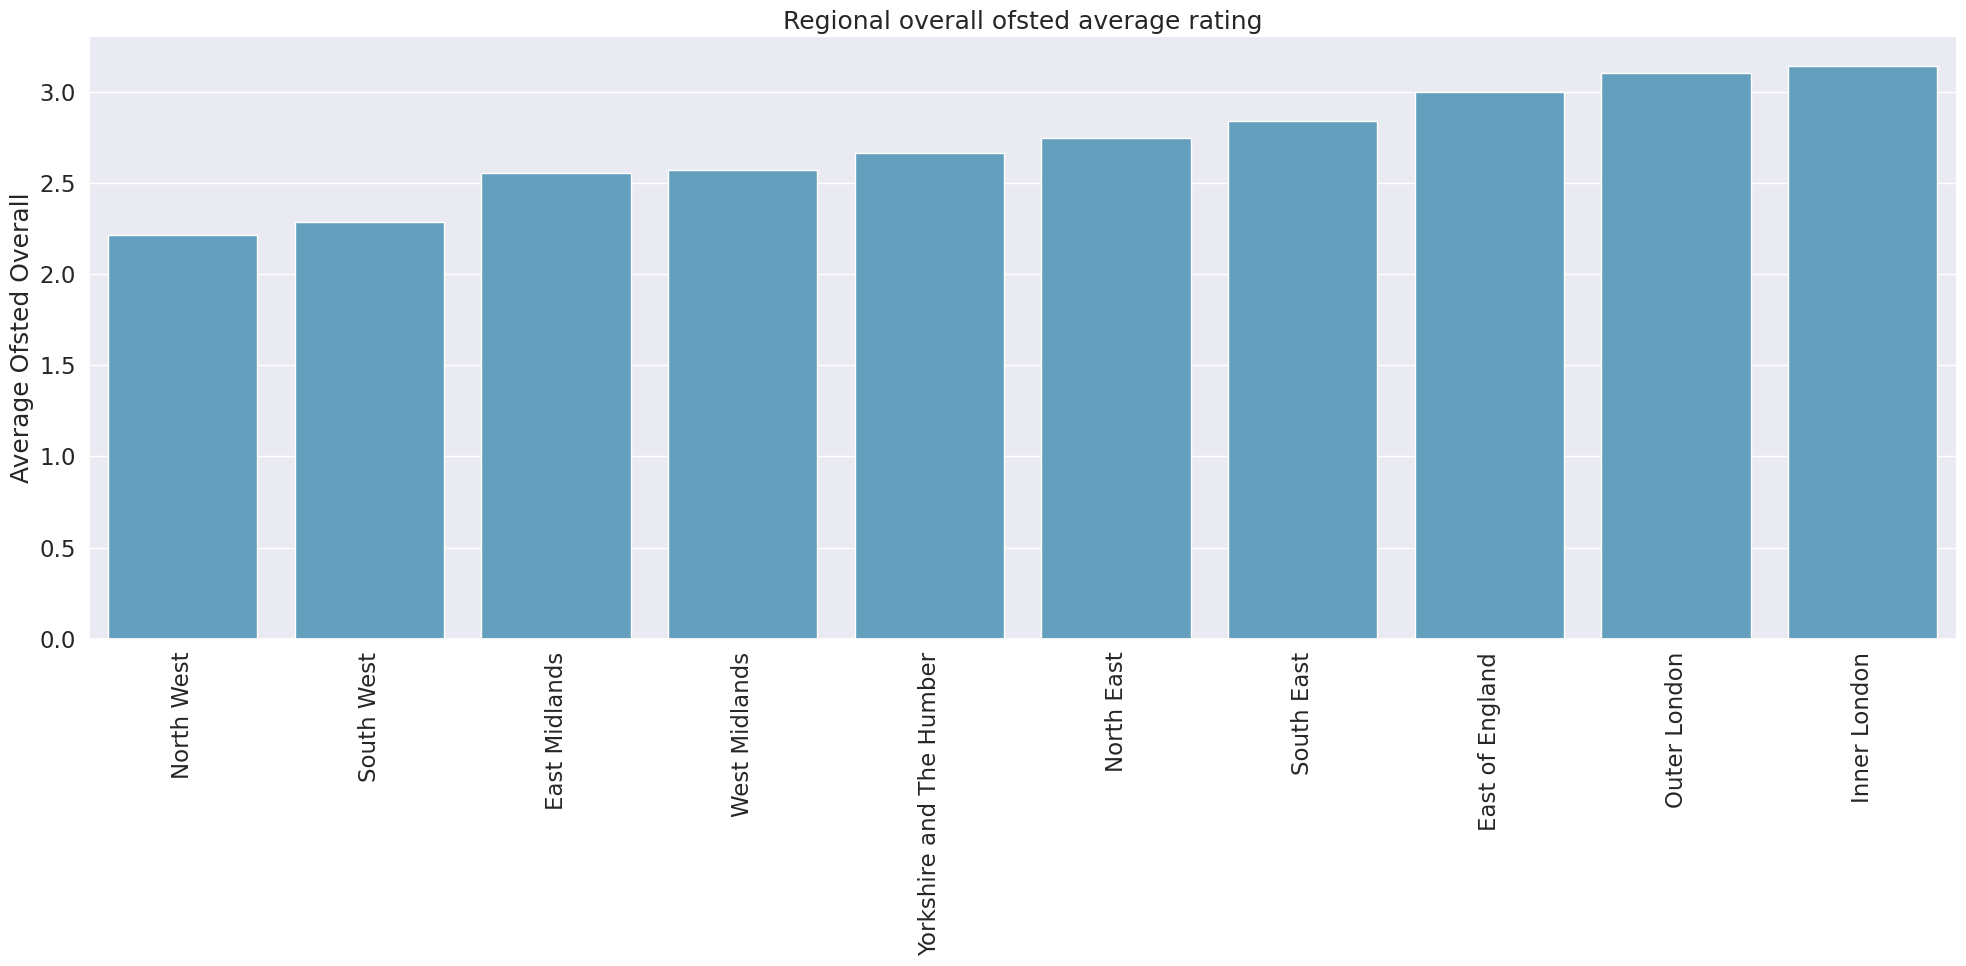

In [28]:
#visualize the different ofsted ratings per national region
sns.set_palette("icefire")

regional_averaged_df = df.groupby('region_name').mean(numeric_only = True).reset_index()
plt.figure(figsize=(20, 10))
sns.barplot(data = regional_averaged_df.sort_values(by = 'ofsted_overall'), x = 'region_name', y = 'ofsted_overall')
plt.title('Regional overall ofsted average rating')
sns.despine()
plt.xlabel("")
plt.xticks(rotation=90)
plt.ylabel("Average Ofsted Overall")
plt.tight_layout()
plt.savefig("ofstedbyregion.pdf")
plt.show()


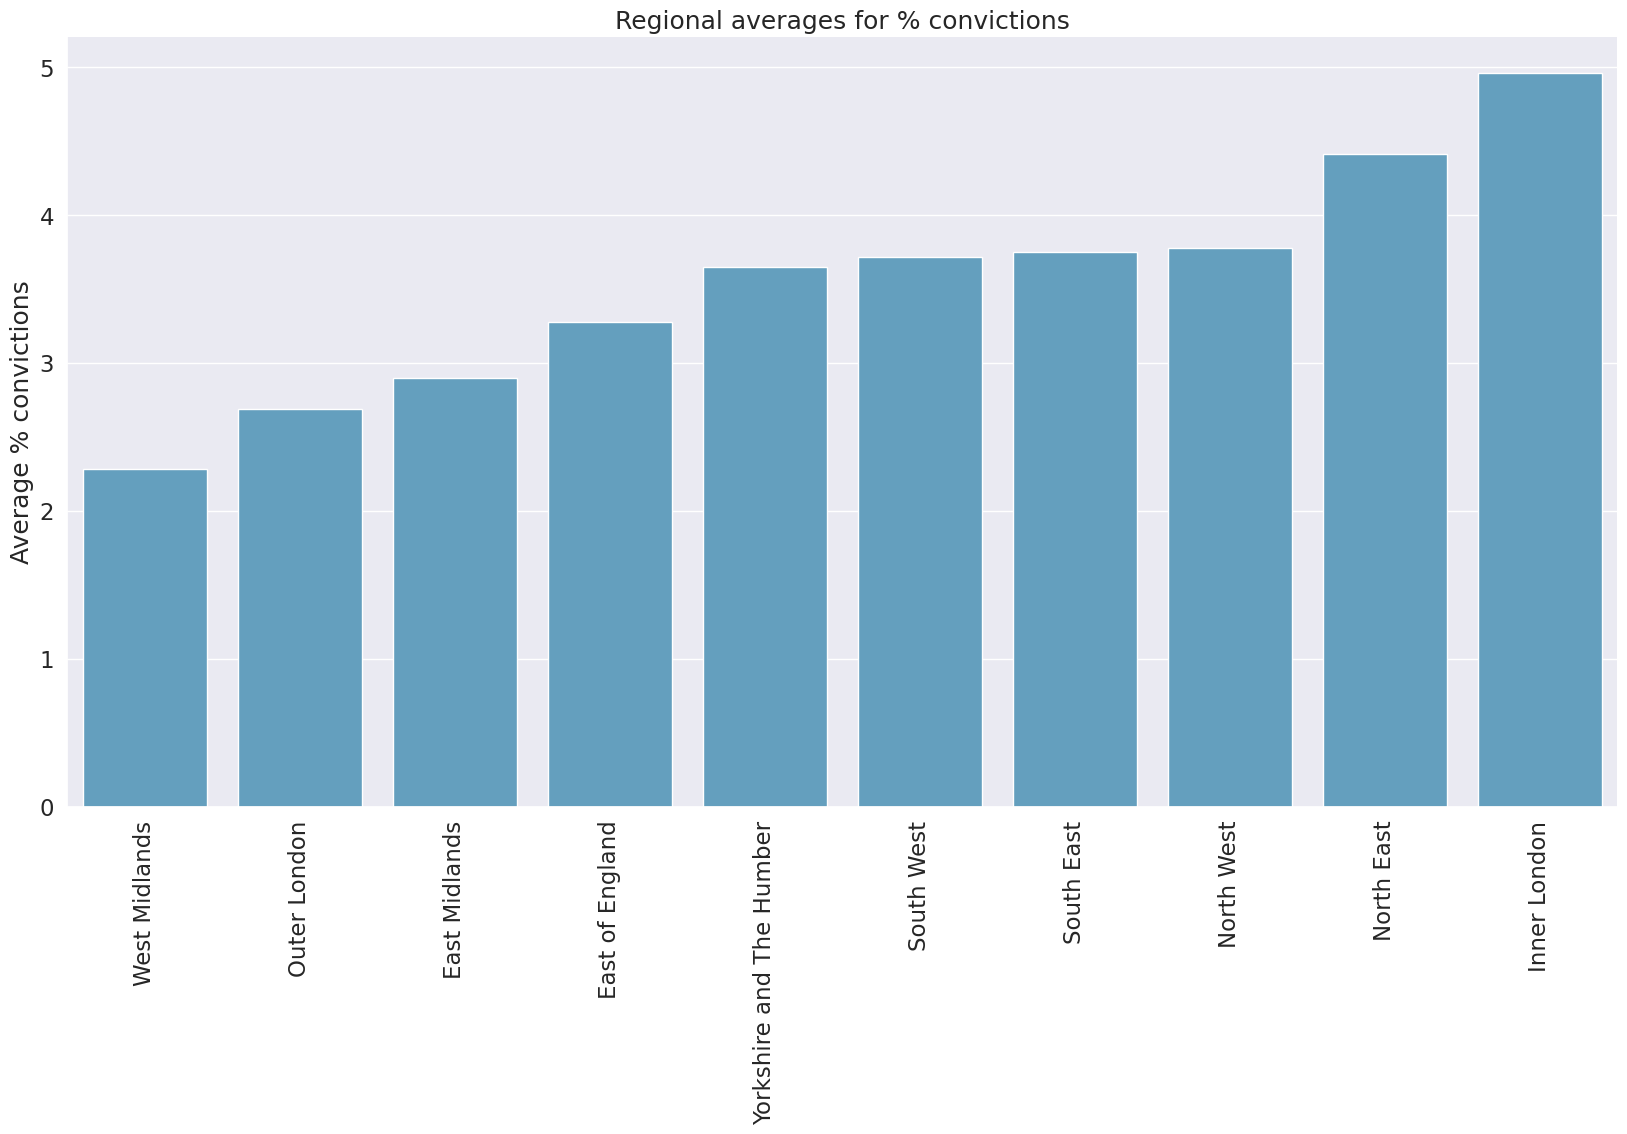

In [29]:
plt.figure(figsize=(20, 10))
sns.barplot(data = regional_averaged_df.sort_values(by = 'pt_convictions'), x = 'region_name', y = 'pt_convictions')
plt.title('Regional averages for % convictions')
sns.despine()
plt.xlabel("")
plt.xticks(rotation=90)
plt.ylabel("Average % convictions")
plt.savefig("convictionsbyregion.pdf")
plt.show()

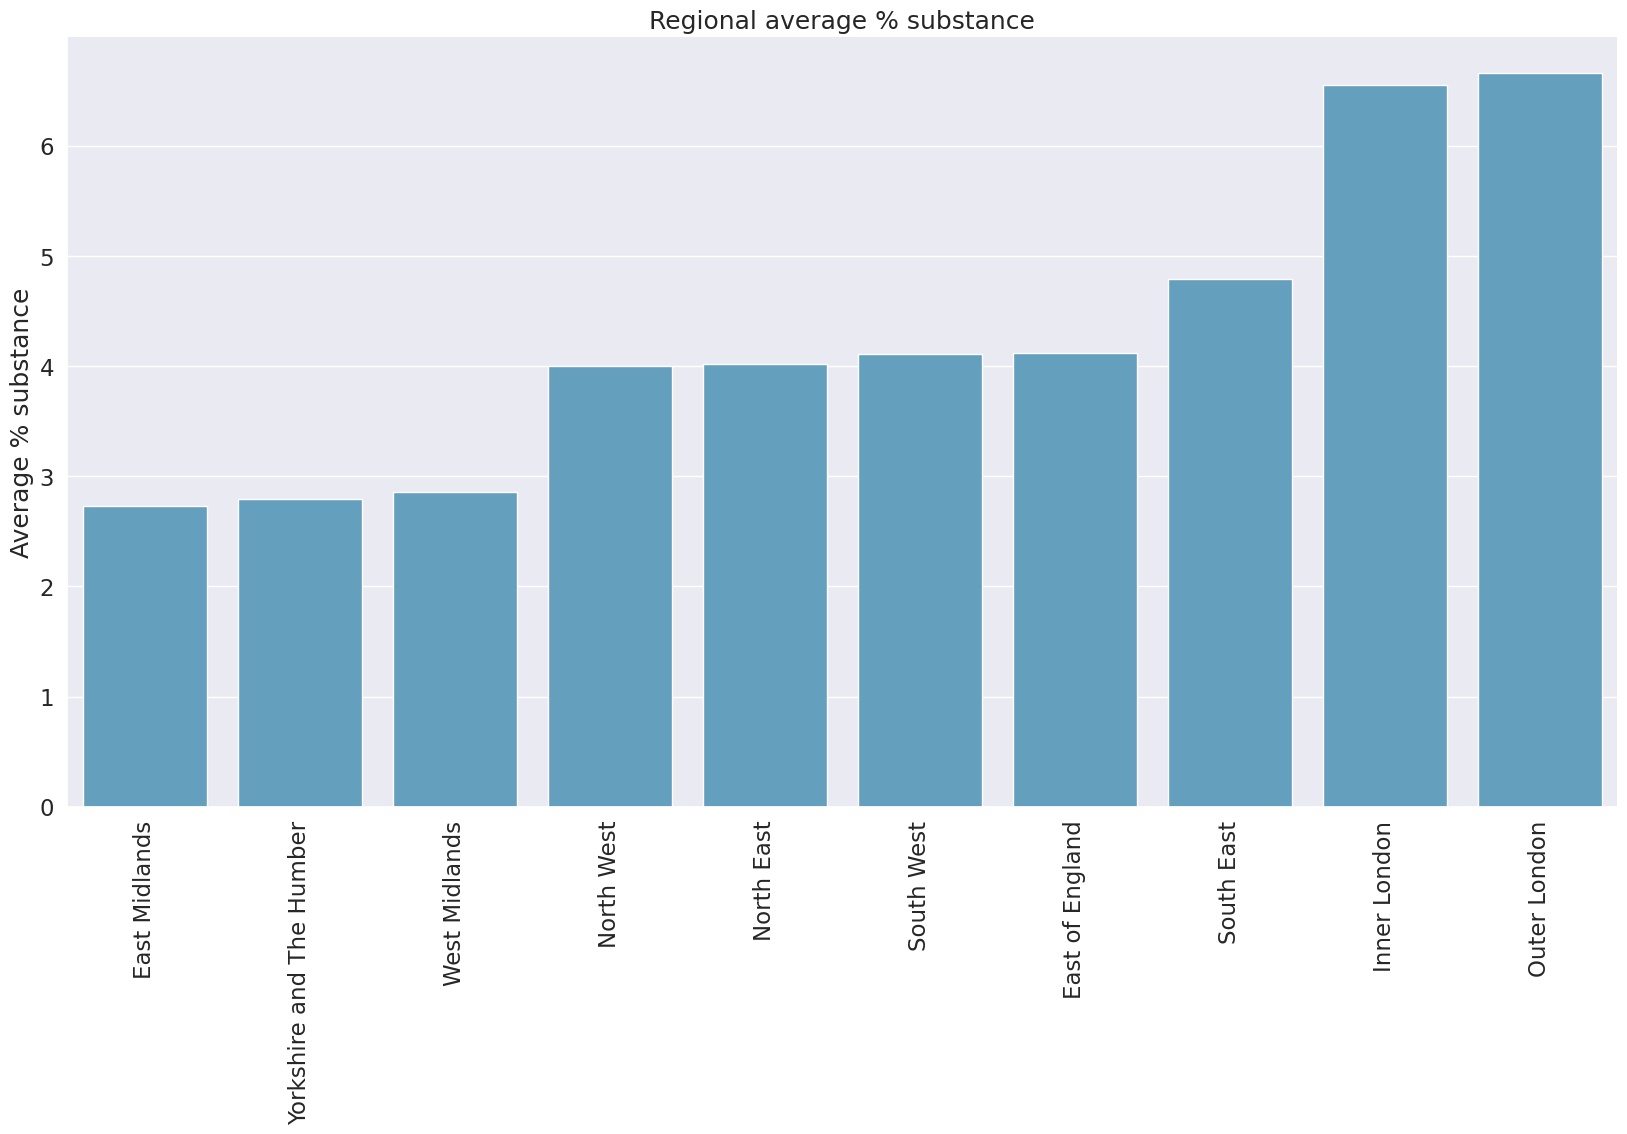

In [30]:
plt.figure(figsize=(20, 10))
sns.barplot(data = regional_averaged_df.sort_values(by = 'pt_substance'), x = 'region_name', y = 'pt_substance')
plt.title('Regional average % substance')
sns.despine()
plt.xlabel("")
plt.xticks(rotation=90)
plt.ylabel("Average % substance")
plt.savefig("substancebyregion.pdf")
plt.show()

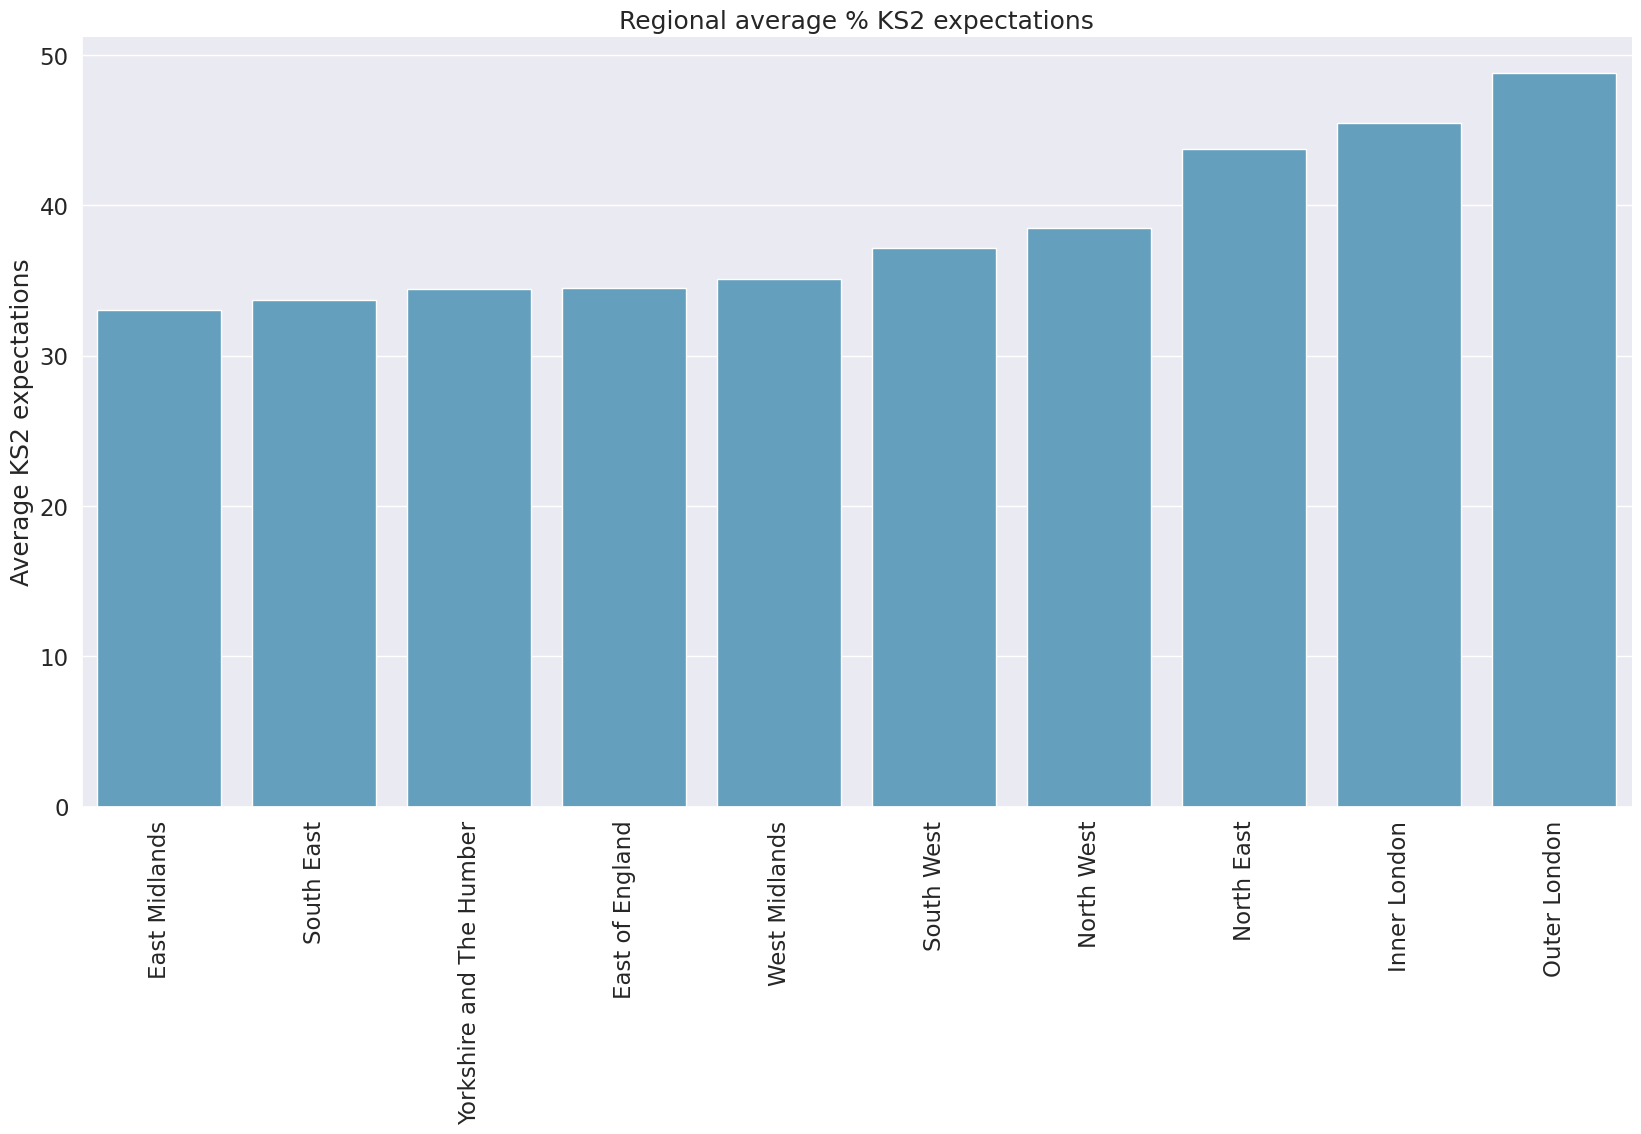

In [31]:
plt.figure(figsize=(20, 10))
sns.barplot(data = regional_averaged_df.sort_values(by = 'pt_ks2_expectations'), x = 'region_name', y = 'pt_ks2_expectations')
plt.title('Regional average % KS2 expectations')
sns.despine()
plt.xlabel("")
plt.xticks(rotation=90)
plt.ylabel("Average KS2 expectations")
plt.savefig("ks2byregion.pdf")
plt.show()

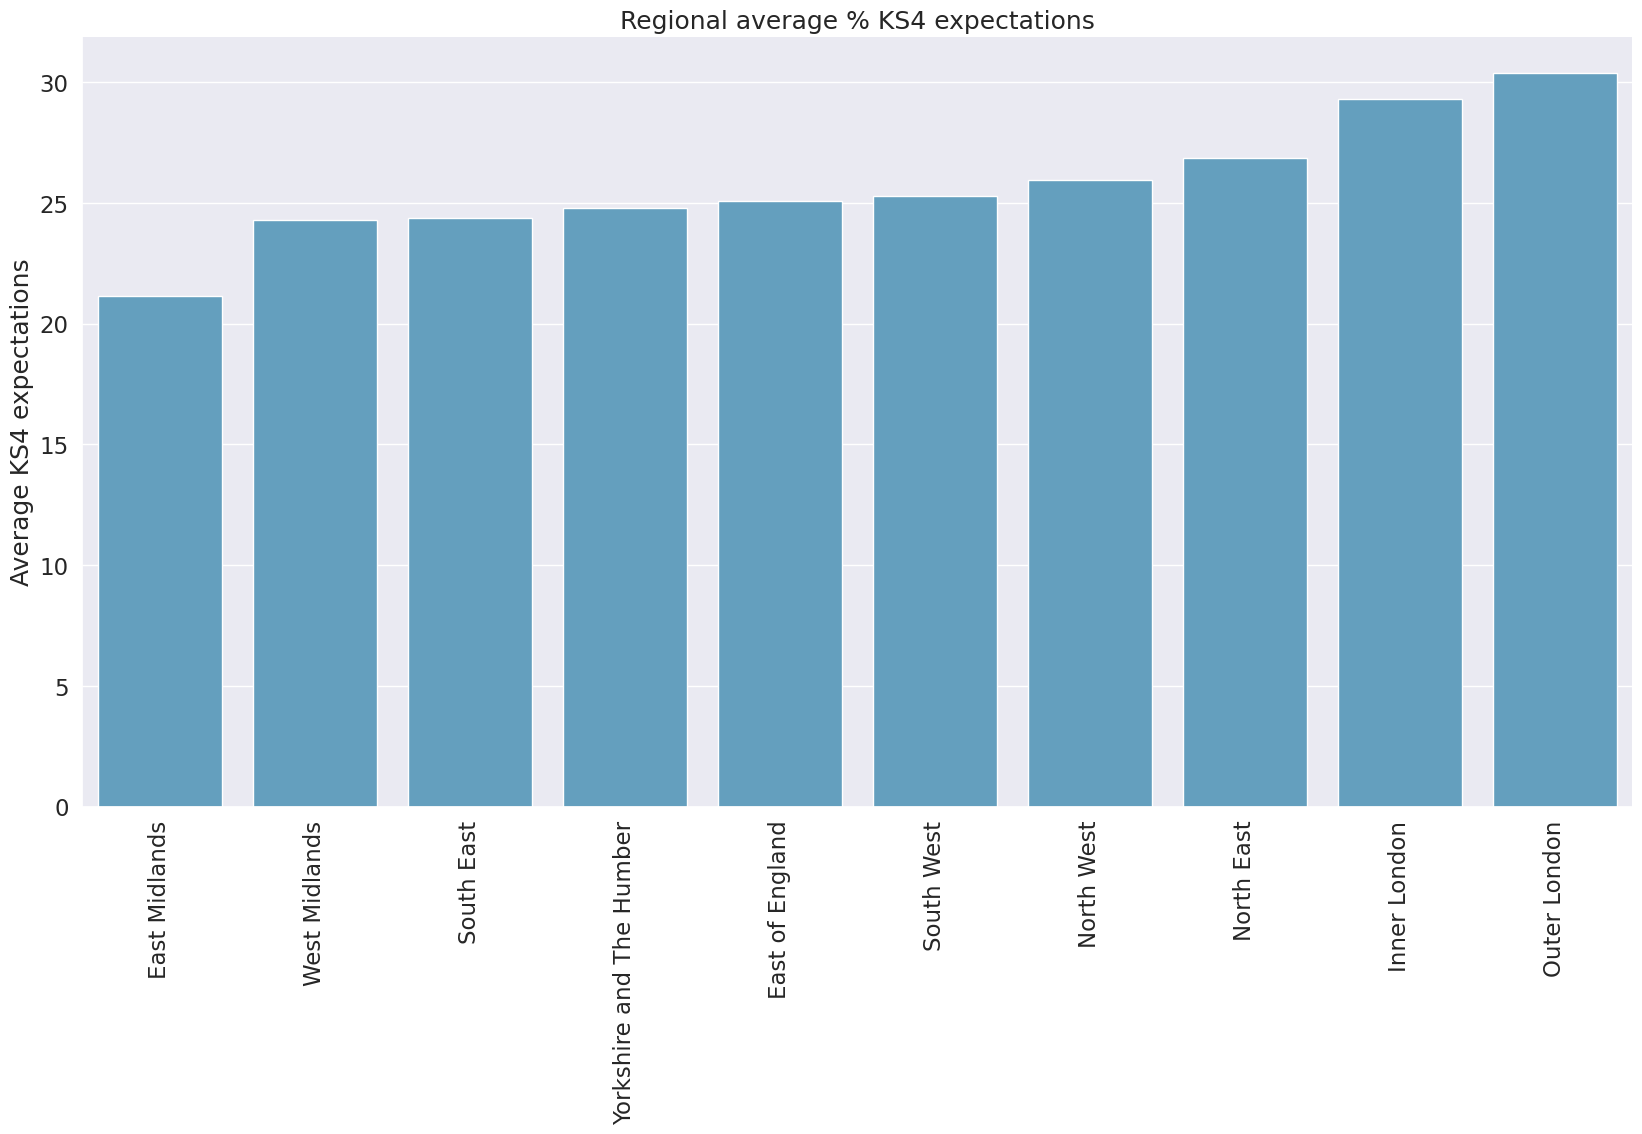

In [32]:
plt.figure(figsize=(20, 10))
sns.barplot(data = regional_averaged_df.sort_values(by = 'pt_ks4_expectations'), x = 'region_name', y = 'pt_ks4_expectations')
plt.title('Regional average % KS4 expectations')
sns.despine()
plt.xlabel("")
plt.xticks(rotation=90)
plt.ylabel("Average KS4 expectations")
plt.savefig("ks4byregion.pdf")
plt.show()

## Look at relationships between variables

In [49]:
#look at the correlation matrix
df.corr(numeric_only = True)

,Unnamed: 0,reporting_year,academic_year,pt_ks2_expectations,pt_ks4_expectations,avg_p8score,num_convictions,num_placed_inside_la,pt_convictions,pt_placed_inside_la,...,pt_ks2_expectations_filled,pt_ks4_expectations_filled,avg_p8score_filled,per_child_spend,cla_budget_filled,ofsted_overall_filled,ofsted_leaders_filled,ofsted_care_filled,ofsted_help_protection_filled,budget_per_child
Unnamed: 0,1.000000e+00,-9.726630e-01,-9.726630e-01,0.197772,-0.242723,0.071310,0.163354,-0.082792,0.272279,-0.059157,...,0.120214,-0.299015,0.066930,-0.180532,-0.173835,3.952222e-02,4.389763e-02,2.410723e-02,3.564680e-02,-0.180532
reporting_year,-9.726630e-01,1.000000e+00,1.000000e+00,-0.215788,0.266439,-0.067019,-0.188428,0.022652,-0.283095,-0.039774,...,-0.068555,0.328585,-0.064137,0.297098,0.169733,2.365496e-14,3.046467e-14,6.203030e-14,1.130821e-14,0.297098
academic_year,-9.726630e-01,1.000000e+00,1.000000e+00,-0.215788,0.266439,-0.067019,-0.188428,0.022652,-0.283095,-0.039774,...,-0.068555,0.328585,-0.064137,0.297098,0.169733,-2.613614e-14,-9.684802e-15,-4.362114e-14,-2.433573e-14,0.297098
pt_ks2_expectations,1.977716e-01,-2.157883e-01,-2.157883e-01,1.000000,0.179529,0.036132,-0.054515,-0.332478,0.289587,-0.267272,...,1.000000,0.129434,0.036132,-0.110928,-0.356790,-1.561830e-02,-4.187335e-02,-4.519374e-02,-1.105047e-02,-0.110928
pt_ks4_expectations,-2.427232e-01,2.664389e-01,2.664389e-01,0.179529,1.000000,0.247217,-0.276249,-0.260208,-0.041164,-0.224254,...,0.194254,1.000000,0.031616,0.145638,-0.201213,-5.943376e-04,-5.695585e-02,-5.260208e-02,3.469895e-03,0.145638
avg_p8score,7.131024e-02,-6.701929e-02,-6.701929e-02,0.036132,0.247217,1.000000,0.072585,0.074111,-0.125783,0.019635,...,-0.030950,0.105947,1.000000,-0.015726,0.054972,4.664392e-02,4.487629e-02,1.916529e-02,2.366944e-02,-0.015726
num_convictions,1.633540e-01,-1.884282e-01,-1.884282e-01,-0.054515,-0.276249,0.072585,1.000000,0.594658,0.561692,0.238619,...,-0.129341,-0.242851,0.065586,-0.117633,0.554114,3.348353e-02,2.458154e-03,4.319341e-02,7.651232e-02,-0.117633
num_placed_inside_la,-8.279213e-02,2.265185e-02,2.265185e-02,-0.332478,-0.260208,0.074111,0.594658,1.000000,-0.117897,0.627488,...,-0.345169,-0.198436,0.080352,-0.186896,0.862049,2.017786e-02,2.522888e-02,6.012642e-02,-3.389478e-02,-0.186896
pt_convictions,2.722786e-01,-2.830951e-01,-2.830951e-01,0.289587,-0.041164,-0.125783,0.561692,-0.117897,1.000000,-0.084255,...,0.140428,-0.072436,-0.124135,-0.104150,-0.122367,-5.195870e-02,-8.833845e-02,-4.267968e-02,4.768217e-02,-0.104150
pt_placed_inside_la,-5.915740e-02,-3.977366e-02,-3.977366e-02,-0.267272,-0.224254,0.019635,0.238619,0.627488,-0.084255,1.000000,...,-0.395203,-0.189390,0.035794,-0.364751,0.332832,-4.117013e-02,-4.534393e-02,6.060096e-03,-7.005759e-02,-0.364751


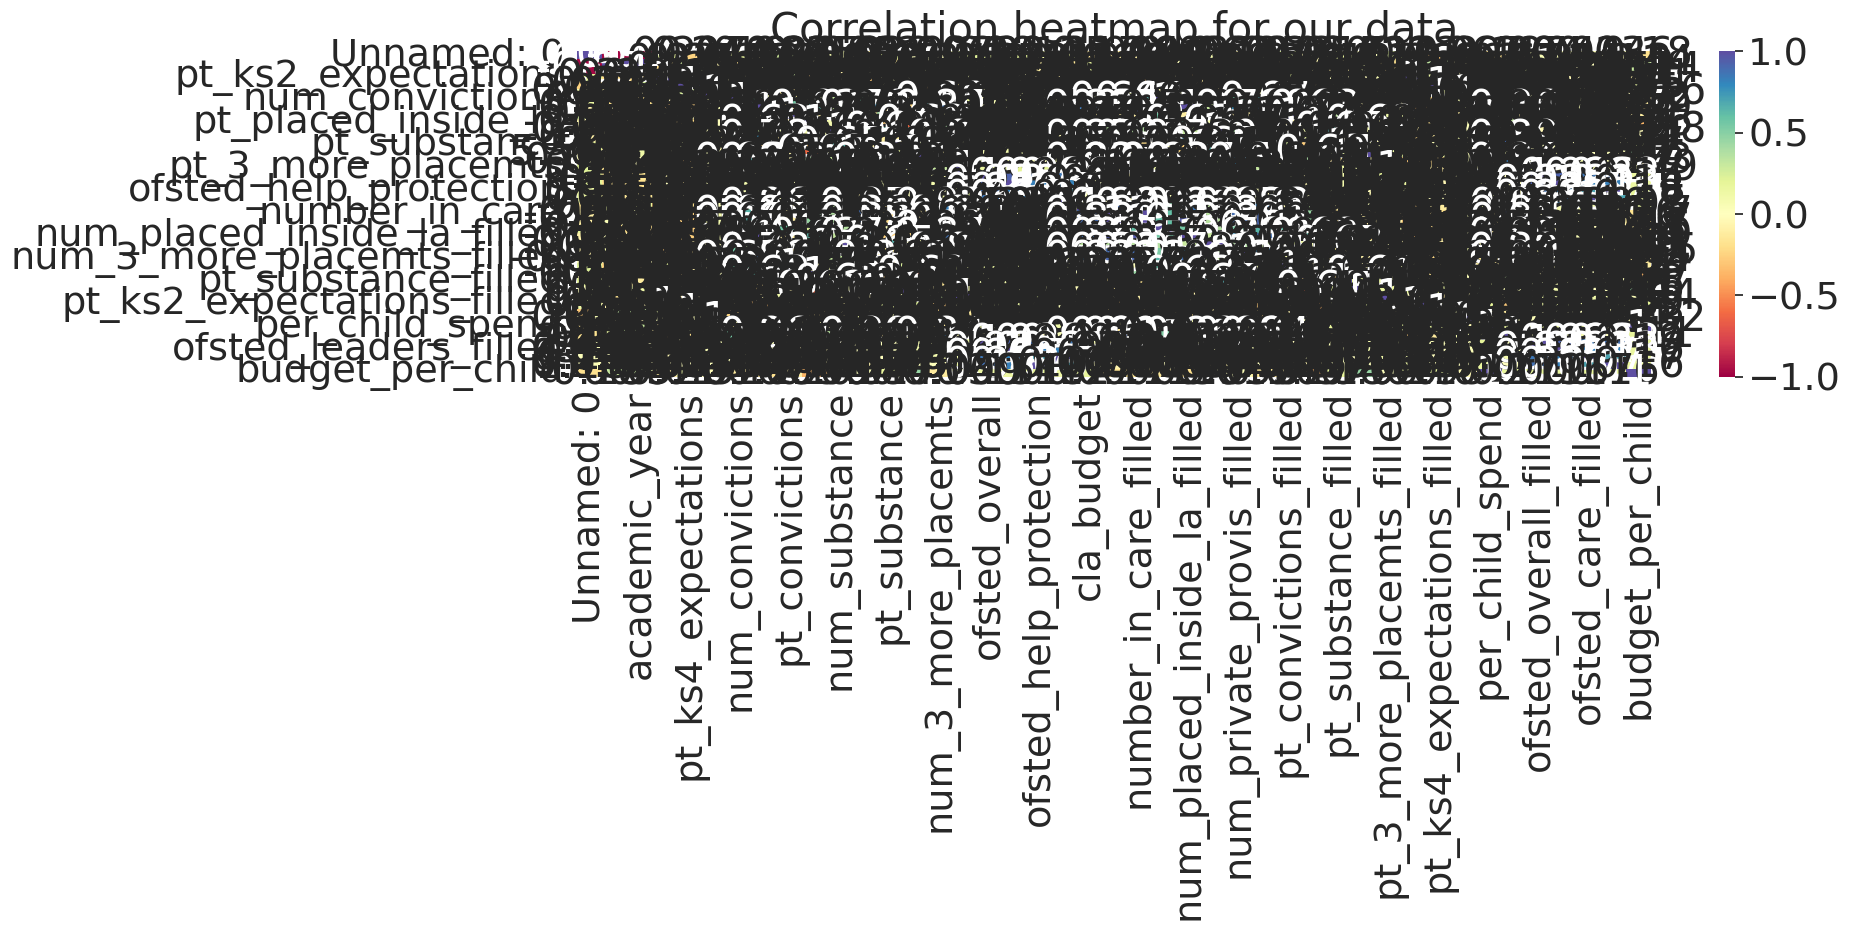

In [50]:
plt.figure(figsize = (20,10))
sns.heatmap(df.corr(numeric_only = True), cmap = 'Spectral', annot = True, vmax = 1, vmin = -1)
plt.title("Correlation heatmap for our data")
plt.tight_layout()

The above is very confusing, so below we have the equivalent for each of the unfilled / filled versions of the features separately.

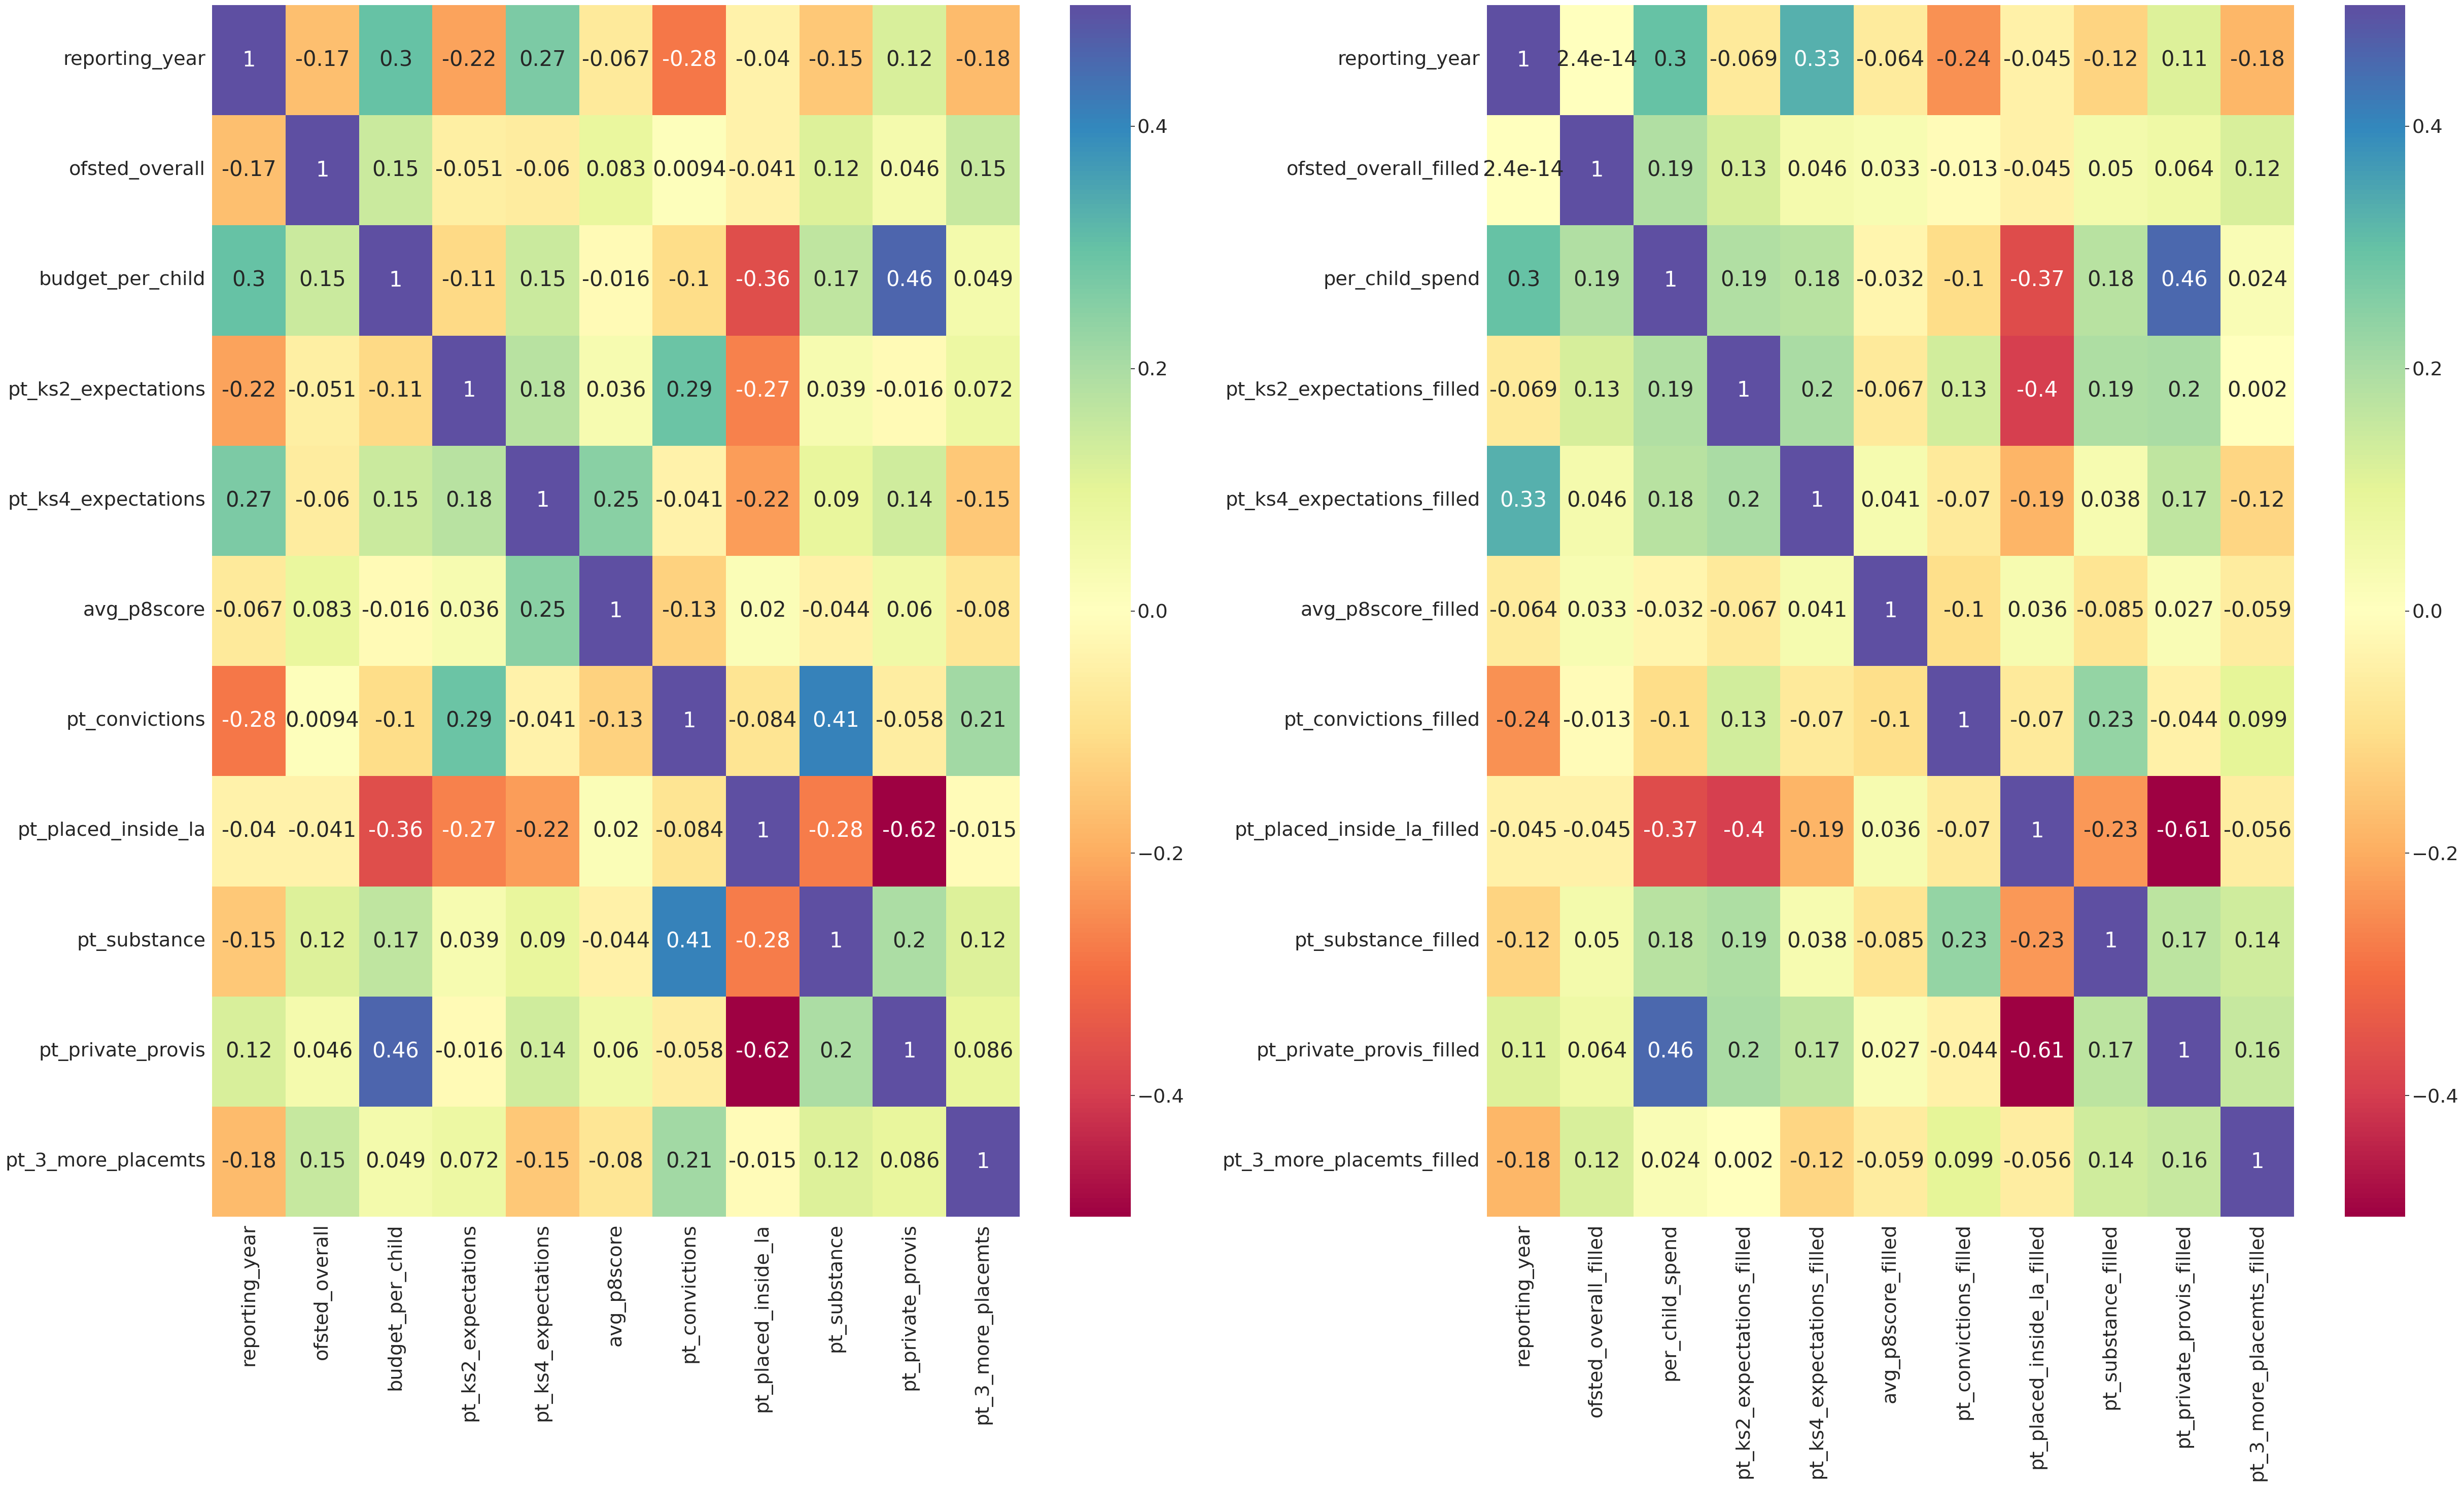

In [57]:
#compare correlation heatmap for filled and unfilled data separately

sns.set(font_scale=2.5)
fig, axes = plt.subplots(nrows = 1, ncols = 2, figsize = (50,30))
sns.heatmap(df_original.corr(numeric_only = True), cmap = 'Spectral', vmax = 0.5, vmin = -0.5, annot = True, ax = axes[0])

sns.heatmap(df_filled.corr(numeric_only = True), cmap = 'Spectral', vmax = 0.5, annot = True, vmin = -0.5, ax = axes[1])


plt.tight_layout()
plt.savefig("heatmaps.pdf")

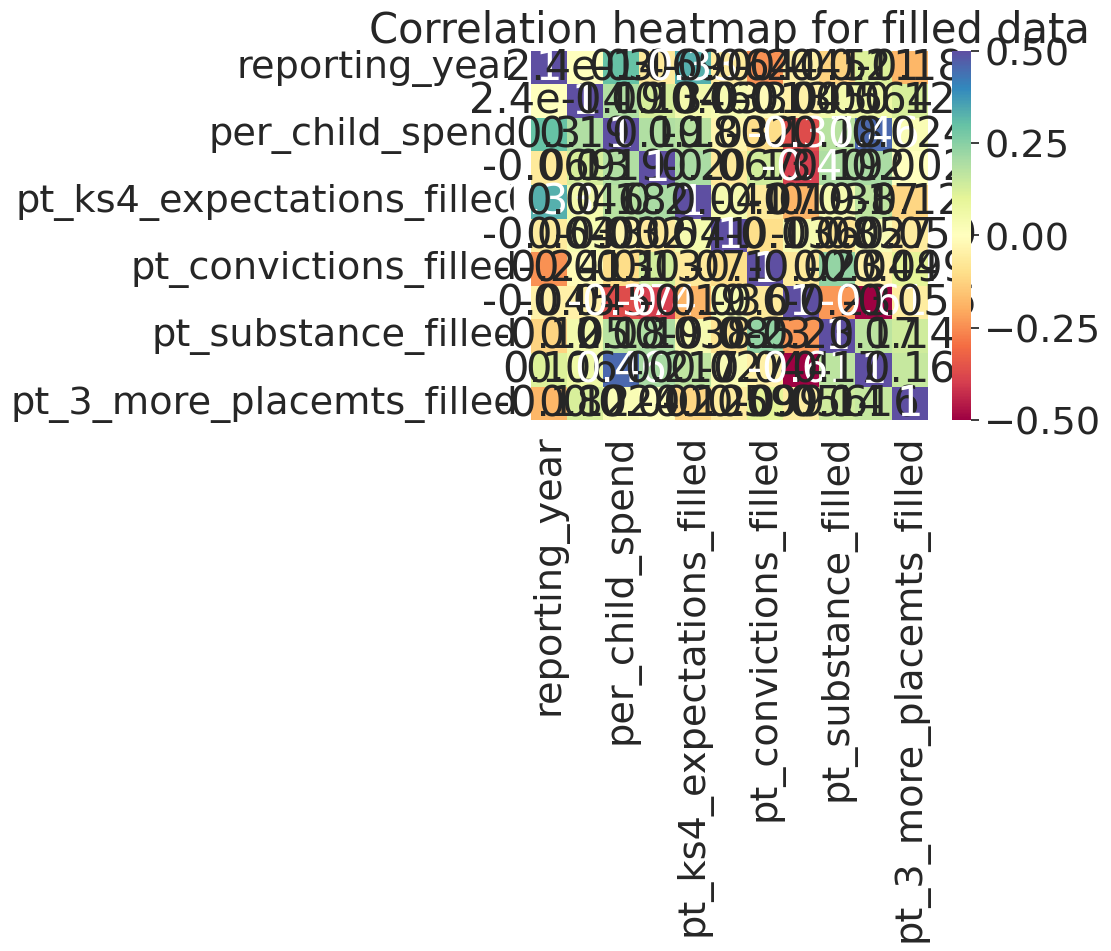

In [52]:
sns.heatmap(df_filled.corr(numeric_only = True), cmap = 'Spectral', vmax = 0.5, annot = True, vmin = -0.5)
plt.title("Correlation heatmap for filled data")


plt.savefig("unfilledheatmap.pdf")

## Linear regressions

Initial exploratory linear regressions (one for each output variable chosen). These are conducted on unfilled data with the averaged dataframe to avoid issues with NaN values.

In [37]:

#first model full LR on % of children with grade 4 english and maths (ks4 outcome)
model1 = smf.ols('pt_ks4_expectations ~ budget_per_child +ofsted_overall +pt_3_more_placemts +pt_private_provis +pt_placed_inside_la +ofsted_leaders +ofsted_care+ofsted_help_protection', data = averaged_df).fit()
print(model1.summary())

                             OLS Regression Results                            
Dep. Variable:     pt_ks4_expectations   R-squared:                       0.167
Model:                             OLS   Adj. R-squared:                  0.116
Method:                  Least Squares   F-statistic:                     3.300
Date:                 Wed, 24 Apr 2024   Prob (F-statistic):            0.00182
Time:                         13:40:11   Log-Likelihood:                -478.87
No. Observations:                  141   AIC:                             975.7
Df Residuals:                      132   BIC:                             1002.
Df Model:                            8                                         
Covariance Type:             nonrobust                                         
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
Intercept         

In [38]:
#next full LR on % children with expected attainment at end of ks2
model1 = smf.ols('pt_ks2_expectations ~ budget_per_child +ofsted_overall +pt_3_more_placemts +pt_private_provis +pt_placed_inside_la +ofsted_leaders +ofsted_care+ofsted_help_protection', data = averaged_df).fit()
print(model1.summary())


                             OLS Regression Results                            
Dep. Variable:     pt_ks2_expectations   R-squared:                       0.187
Model:                             OLS   Adj. R-squared:                  0.117
Method:                  Least Squares   F-statistic:                     2.650
Date:                 Wed, 24 Apr 2024   Prob (F-statistic):             0.0116
Time:                         13:40:11   Log-Likelihood:                -350.59
No. Observations:                  101   AIC:                             719.2
Df Residuals:                       92   BIC:                             742.7
Df Model:                            8                                         
Covariance Type:             nonrobust                                         
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
Intercept         

In [39]:
#next full LR on % children who receive criminal conviction or caution
model1 = smf.ols('pt_convictions ~ budget_per_child +ofsted_overall +pt_3_more_placemts +pt_private_provis +pt_placed_inside_la +ofsted_leaders +ofsted_care+ofsted_help_protection', data = averaged_df).fit()
print(model1.summary())


                            OLS Regression Results                            
Dep. Variable:         pt_convictions   R-squared:                       0.077
Model:                            OLS   Adj. R-squared:                  0.020
Method:                 Least Squares   F-statistic:                     1.358
Date:                Wed, 24 Apr 2024   Prob (F-statistic):              0.221
Time:                        13:40:11   Log-Likelihood:                -298.50
No. Observations:                 139   AIC:                             615.0
Df Residuals:                     130   BIC:                             641.4
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
Intercept                  3

In [40]:
#full LR on % substance
model1 = smf.ols('pt_substance ~ budget_per_child +ofsted_overall +pt_3_more_placemts +pt_private_provis +pt_placed_inside_la +ofsted_leaders +ofsted_care+ofsted_help_protection', data = averaged_df).fit()
print(model1.summary())

                            OLS Regression Results                            
Dep. Variable:           pt_substance   R-squared:                       0.147
Model:                            OLS   Adj. R-squared:                  0.097
Method:                 Least Squares   F-statistic:                     2.955
Date:                Wed, 24 Apr 2024   Prob (F-statistic):            0.00443
Time:                        13:40:11   Log-Likelihood:                -364.81
No. Observations:                 146   AIC:                             747.6
Df Residuals:                     137   BIC:                             774.5
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
Intercept                  3

Now do the same as above, but redo the 4 models only using Ofsted features, to try and assess if there's relationships there.

In [41]:
#next simple LR ofsted -> % who received conviction
model1 = smf.ols('pt_convictions~ ofsted_overall +ofsted_leaders +ofsted_care+ofsted_help_protection', data = averaged_df).fit()
print(model1.summary())


                            OLS Regression Results                            
Dep. Variable:         pt_convictions   R-squared:                       0.039
Model:                            OLS   Adj. R-squared:                  0.010
Method:                 Least Squares   F-statistic:                     1.362
Date:                Wed, 24 Apr 2024   Prob (F-statistic):              0.251
Time:                        13:40:11   Log-Likelihood:                -301.31
No. Observations:                 139   AIC:                             612.6
Df Residuals:                     134   BIC:                             627.3
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
Intercept                  3

In [42]:
#next simple LR ofsted -> % substance misuse problems
model1 = smf.ols('pt_substance~ ofsted_overall +ofsted_leaders +ofsted_care+ofsted_help_protection', data = averaged_df).fit()
print(model1.summary())


                            OLS Regression Results                            
Dep. Variable:           pt_substance   R-squared:                       0.005
Model:                            OLS   Adj. R-squared:                 -0.024
Method:                 Least Squares   F-statistic:                    0.1628
Date:                Wed, 24 Apr 2024   Prob (F-statistic):              0.957
Time:                        13:40:11   Log-Likelihood:                -376.09
No. Observations:                 146   AIC:                             762.2
Df Residuals:                     141   BIC:                             777.1
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
Intercept                  4

In [43]:
#simple LR ofsted -> % who achieved expected standard at end of ks2
model1 = smf.ols('pt_ks2_expectations~ ofsted_overall +ofsted_leaders +ofsted_care+ofsted_help_protection', data = averaged_df).fit()
print(model1.summary())

#corresponds to q3

                             OLS Regression Results                            
Dep. Variable:     pt_ks2_expectations   R-squared:                       0.020
Model:                             OLS   Adj. R-squared:                 -0.021
Method:                  Least Squares   F-statistic:                    0.4790
Date:                 Wed, 24 Apr 2024   Prob (F-statistic):              0.751
Time:                         13:40:11   Log-Likelihood:                -360.07
No. Observations:                  101   AIC:                             730.1
Df Residuals:                       96   BIC:                             743.2
Df Model:                            4                                         
Covariance Type:             nonrobust                                         
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
Intercept         

In [44]:
#simple LR -> ofsted % with grade 4 english and maths
model1 = smf.ols('pt_ks4_expectations~ ofsted_overall +ofsted_leaders +ofsted_care+ofsted_help_protection', data = averaged_df).fit()
print(model1.summary())

#corresponds to q3

                             OLS Regression Results                            
Dep. Variable:     pt_ks4_expectations   R-squared:                       0.059
Model:                             OLS   Adj. R-squared:                  0.031
Method:                  Least Squares   F-statistic:                     2.127
Date:                 Wed, 24 Apr 2024   Prob (F-statistic):             0.0808
Time:                         13:40:11   Log-Likelihood:                -487.45
No. Observations:                  141   AIC:                             984.9
Df Residuals:                      136   BIC:                             999.6
Df Model:                            4                                         
Covariance Type:             nonrobust                                         
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
Intercept         

## Looking at changes in variables over time

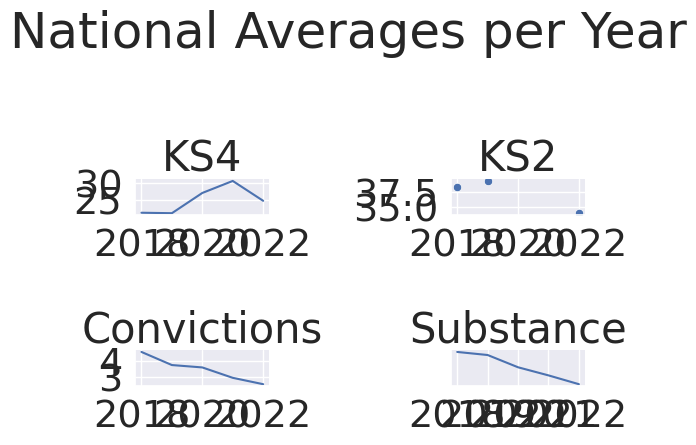

In [45]:
#start at a national level, lineplot ofsted ratings and % children with grade 4 english and maths
national_averages_per_year = df.groupby('reporting_year')[['pt_ks4_expectations', 'pt_convictions', 'pt_substance', 'pt_ks2_expectations']].mean()
fig, ax = plt.subplots(nrows =  2, ncols = 2)
national_averages_per_year['reporting_year'] = national_averages_per_year.index
sns.set_palette("Set2")
sns.lineplot(data = national_averages_per_year, x = 'reporting_year', y = 'pt_ks4_expectations', ax = ax[0,0])
ax[0,0].set_title("KS4")
ax[0,0].set_ylabel("")
ax[0,0].set_xlabel("")
sns.scatterplot(data = national_averages_per_year, x = 'reporting_year', y = 'pt_ks2_expectations', ax = ax[0,1])
ax[0,1].set_title("KS2")
ax[0,1].set_ylabel("")
ax[0,1].set_xlabel("")

#KS2 data has to be represented as a scatterplot rather than a line plot - as we have 2 years of missing data
sns.lineplot(data = national_averages_per_year, x = 'reporting_year', y = 'pt_convictions', ax = ax[1,0])
ax[1,0].set_title("Convictions")
ax[1,0].set_ylabel("")
ax[1,0].set_xlabel("")
sns.lineplot(data = national_averages_per_year, x = 'reporting_year', y = 'pt_substance', ax = ax[1,1])
ax[1,1].set_title("Substance")
ax[1,1].set_ylabel("")
ax[1,1].set_xlabel("")

plt.yticks([])
plt.xticks(national_averages_per_year['reporting_year'])
fig.suptitle("National Averages per Year")

sns.despine()
plt.tight_layout()
plt.savefig("nationalavgs.pdf")

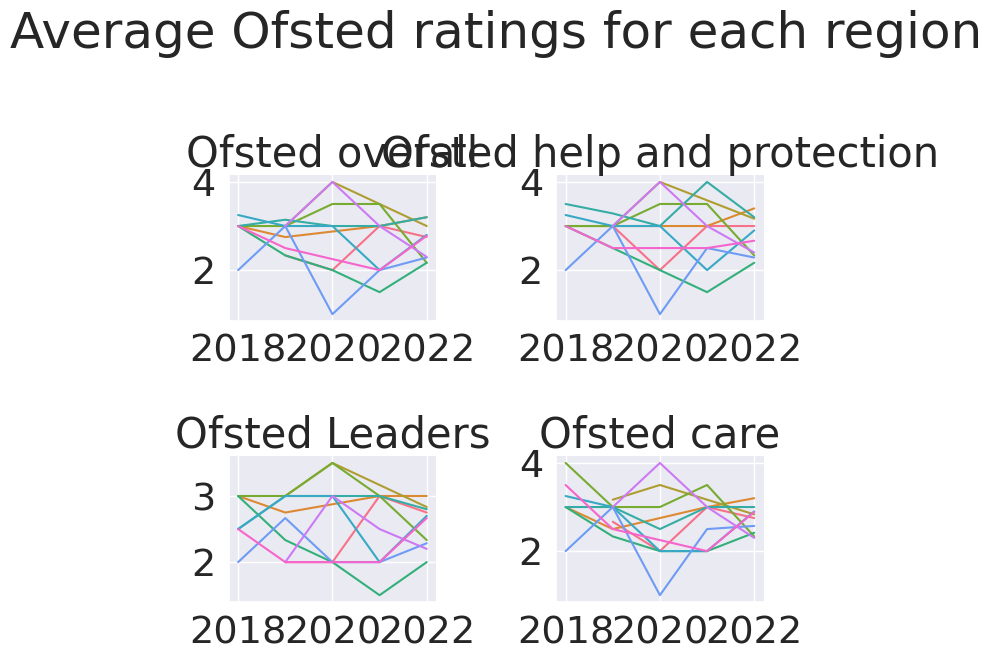

In [46]:
#then do the same for each region
sns.set_palette("Set2")
regional_averages_per_year = df.groupby(['region_name', 'reporting_year'])[['ofsted_overall', 'pt_ks4_expectations', 'pt_ks2_expectations', 'pt_convictions', 'pt_substance', 'ofsted_care', 'ofsted_help_protection', 'ofsted_leaders']].mean().reset_index()
fig, axes = plt.subplots(nrows = 2, ncols = 2, figsize = (7,7))
sns.lineplot(data = regional_averages_per_year, x = 'reporting_year', y = 'ofsted_overall', hue = 'region_name', ax = axes[0,0], legend = False)
sns.despine()
sns.lineplot(data = regional_averages_per_year, x = 'reporting_year', y = 'ofsted_leaders', hue = 'region_name', ax = axes[0,1], legend = False)
sns.despine()
sns.lineplot(data = regional_averages_per_year, x = 'reporting_year', y = 'ofsted_help_protection', hue = 'region_name', ax = axes[1,0], legend = False)
sns.despine()
sns.lineplot(data = regional_averages_per_year, x = 'reporting_year', y = 'ofsted_care', hue = 'region_name', ax = axes[1,1], legend = False)
sns.despine()
fig.suptitle('Average Ofsted ratings for each region')
axes[0,0].set_ylabel("")
axes[0,0].set_xlabel("")
axes[0,0].set_title("Ofsted overall")
axes[1,0].set_ylabel("")
axes[1,0].set_xlabel("")
axes[1,0].set_title("Ofsted Leaders")
axes[0,1].set_ylabel("")
axes[0,1].set_xlabel("")
axes[0,1].set_title("Ofsted help and protection")
axes[1,1].set_ylabel("")
axes[1,1].set_xlabel("")
axes[1,1].set_title("Ofsted care")
plt.tight_layout()
plt.savefig("ofstedovertime.pdf")

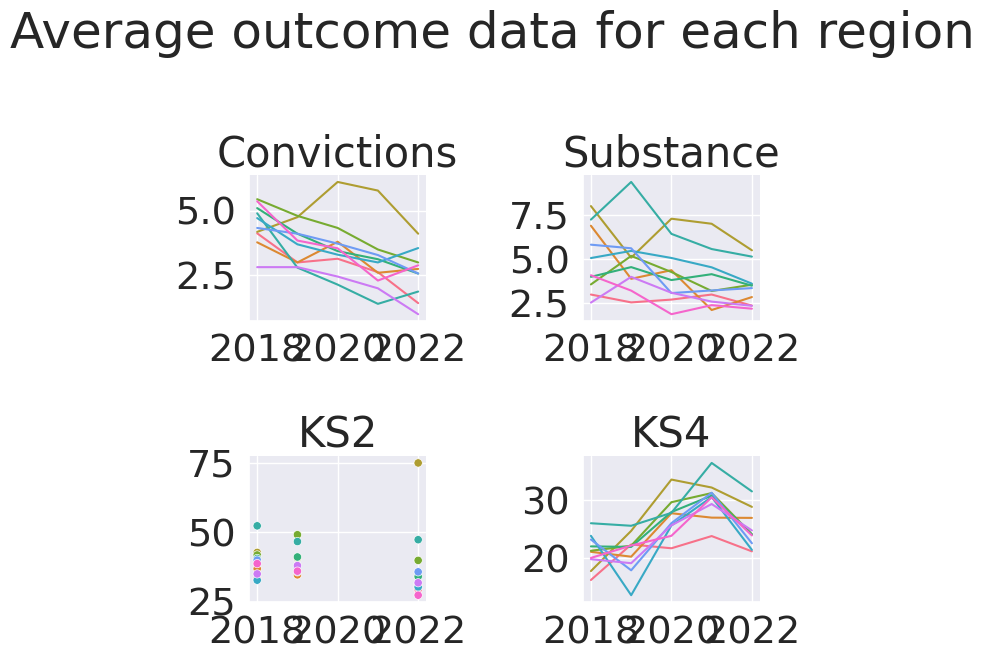

In [47]:
fig, axs = plt.subplots(2,2, figsize = (7,7))


sns.lineplot(data = regional_averages_per_year, x = 'reporting_year', y = 'pt_convictions', hue = 'region_name', ax = axs[0,0], legend = False)
sns.despine()
sns.lineplot(data = regional_averages_per_year, x = 'reporting_year', y = 'pt_substance', hue = 'region_name', ax = axs[0,1], legend = False)
sns.despine()
sns.scatterplot(data = regional_averages_per_year, x = 'reporting_year', y = 'pt_ks2_expectations', hue = 'region_name', ax = axs[1,0], legend = False)
sns.despine()
sns.lineplot(data = regional_averages_per_year, x = 'reporting_year', y = 'pt_ks4_expectations', hue = 'region_name', ax = axs[1,1], legend = False)
sns.despine()
axs[0,0].set_title("Convictions")
axs[0,0].set_xlabel("")
axs[0,0].set_ylabel("")
axs[0,1].set_title("Substance")
axs[0,1].set_xlabel("")
axs[0,1].set_ylabel("")
axs[1,0].set_title("KS2")
axs[1,0].set_xlabel("")
axs[1,0].set_ylabel("")
axs[1,1].set_title("KS4")
axs[1,1].set_xlabel("")
axs[1,1].set_ylabel("")
fig.suptitle('Average outcome data for each region')
plt.tight_layout()
plt.savefig("regionalavgslineplot.pdf")

<ipython-input-48-6b3adfe3875f>:15: UserWarning: Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations
  plt.tight_layout()


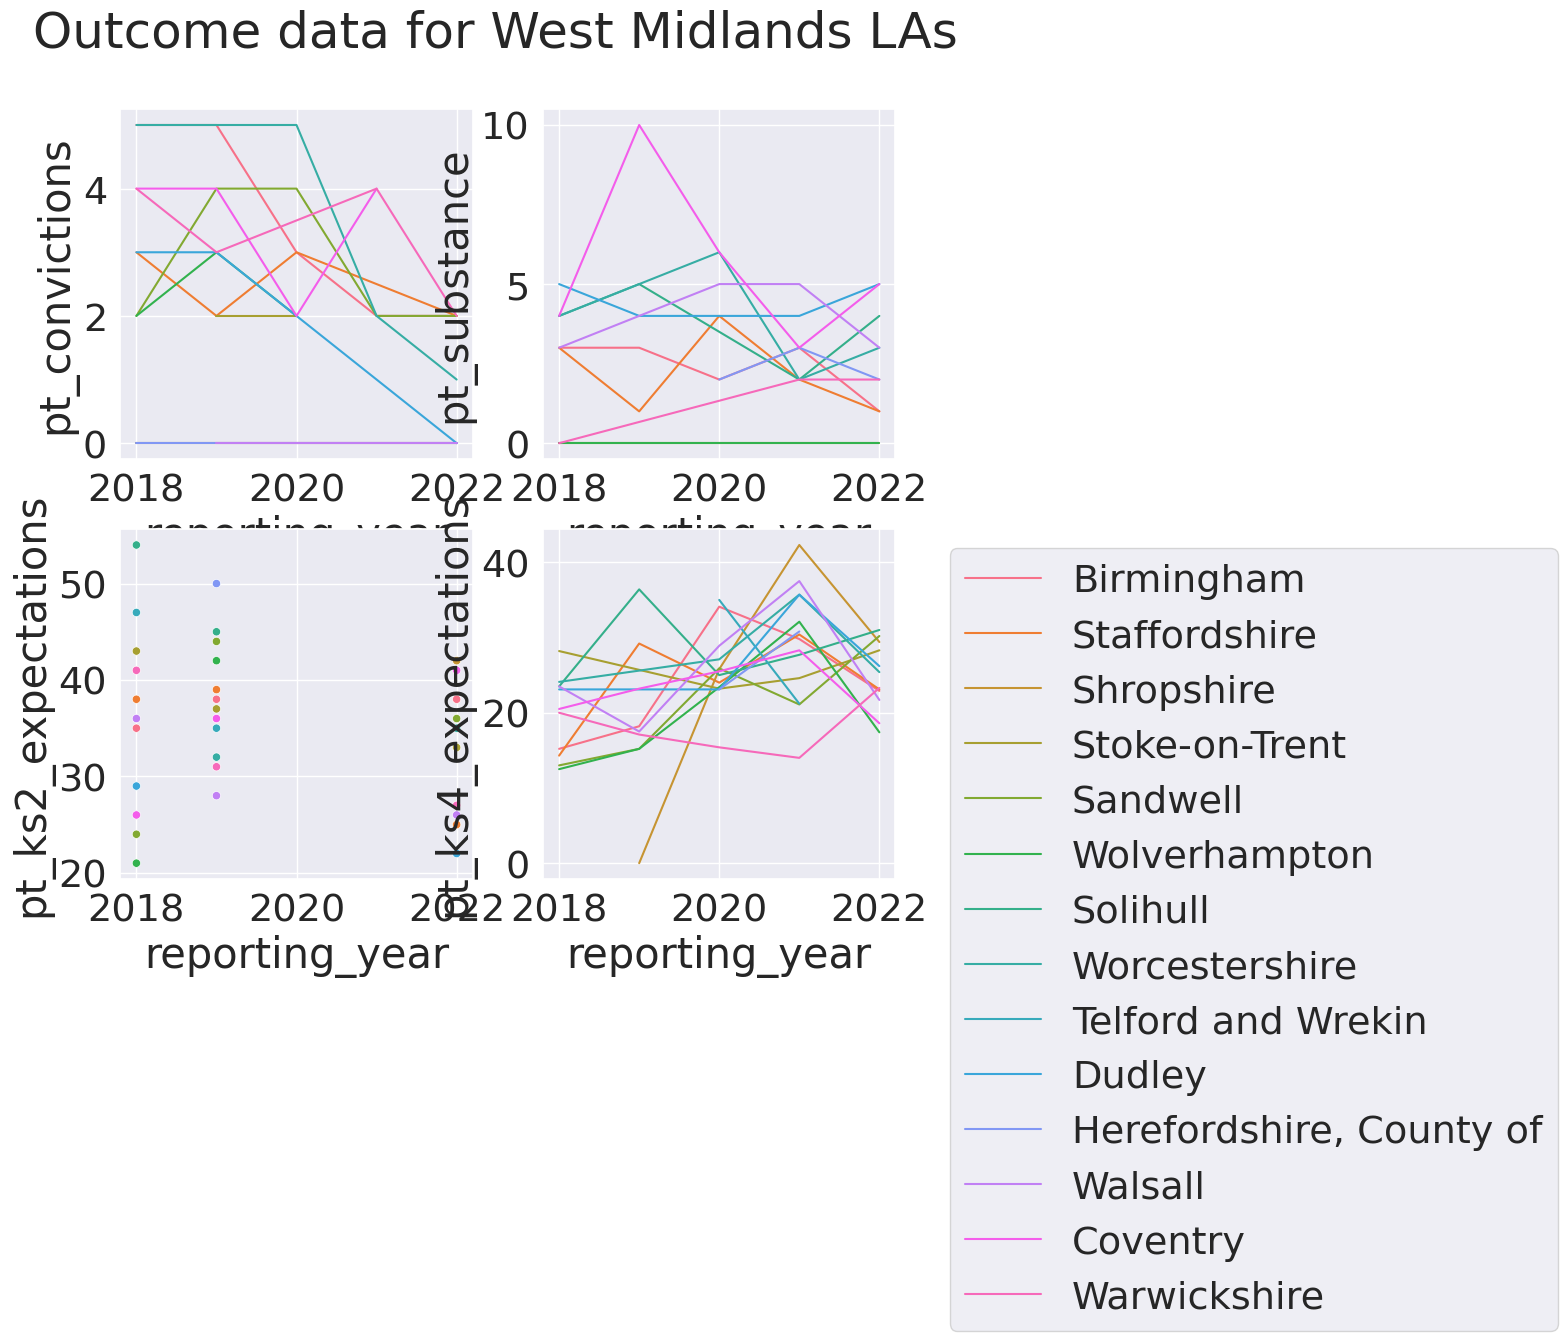

In [48]:
#visualize trends in each local authority in one areas - west midlands

fig, axs = plt.subplots(2,2, figsize = (10,10))

west_midlands = df.query("region_name == 'West Midlands'")
west_midlands = west_midlands.sort_values(by = 'reporting_year')
sns.lineplot(data = west_midlands, x = 'reporting_year', y = 'pt_convictions', hue = 'la_name', ax = axs[0,0], legend = False)
sns.lineplot(data = west_midlands, x = 'reporting_year', y = 'pt_substance', hue = 'la_name', ax = axs[0,1], legend = False)

#chosen a scatterplot for this plot as we have two years of missing data, a line plot is misleading
sns.scatterplot(data = west_midlands, x = 'reporting_year', y = 'pt_ks2_expectations', hue = 'la_name', ax = axs[1,0], legend = False)
sns.lineplot(data = west_midlands, x = 'reporting_year', y = 'pt_ks4_expectations', hue = 'la_name', ax = axs[1,1])
plt.legend(bbox_to_anchor=(1.1, 1), loc='upper left')
fig.suptitle('Outcome data for West Midlands LAs')
plt.tight_layout()
